In [1]:
# Install dependencies
!pip install tcpyPI
!pip install tcvpigpiv
!pip install netCDF4
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 122.4 MB/s eta 0:00:00


In [1]:

# ==== IMPORTS ====
# Required libraries
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LogNorm
from matplotlib import ticker, cm
from datetime import datetime
import tcpyPI
from tcpyPI import pi
import time
import sys
import tcvpigpiv
from tcvpigpiv import compute_gpiv_from_dataset

In [2]:
url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/Q/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.Q.201501-206412.nc'
Q = xr.open_dataset(url).Q.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/T/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.T.201501-206412.nc'
T = xr.open_dataset(url).T.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/U/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.U.201501-206412.nc'
U = xr.open_dataset(url).U.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/V/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.V.201501-206412.nc'
V = xr.open_dataset(url).V.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/PS/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.PS.201501-206412.nc'
SP = xr.open_dataset(url).PS.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/SST/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.SST.201501-206412.nc'
SST = xr.open_dataset(url).SST.isel(time=-1)

R_earth = 6371e3
lat_rad = np.deg2rad(U.lat)

dx = R_earth * np.cos(lat_rad) * np.deg2rad(U.lon.diff('lon'))
dy = R_earth * np.deg2rad(U.lat.diff('lat'))


VO = V.differentiate('lon')/dx - U.differentiate('lat')/dy





In [3]:

ds = xr.merge([Q,T,U,V,SP.rename('SP'),SST.rename('SSTK'),VO.rename('VO')]).rename({'lev':'level','lat':'latitude','lon':'longitude'})
lev_coords = np.sort(np.array((ds.level.values.tolist() + [850,600,200])))[::-1]

# ds = ds.reindex(level=list(reversed(ds.level))).interp
ds = ds.interp(level=lev_coords)


/Users/jocegue/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/jocegue/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


In [4]:
results_ds = compute_gpiv_from_dataset(ds)


  Calculating Potential Intensity (PI)...
  Calculating Vertical Wind Shear (VWS)...
  Calculating Entropy Deficit (Chi)...
  Calculating Capped Vorticity (eta_c)...
  Combining components for final GPIv...


/Users/jocegue/opt/anaconda3/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


In [5]:
vPI = results_ds.vPI
PI = results_ds.PI

/Users/jocegue/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/jocegue/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/jocegue/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/jocegue/opt/anaconda3/lib/python3.9/site-package

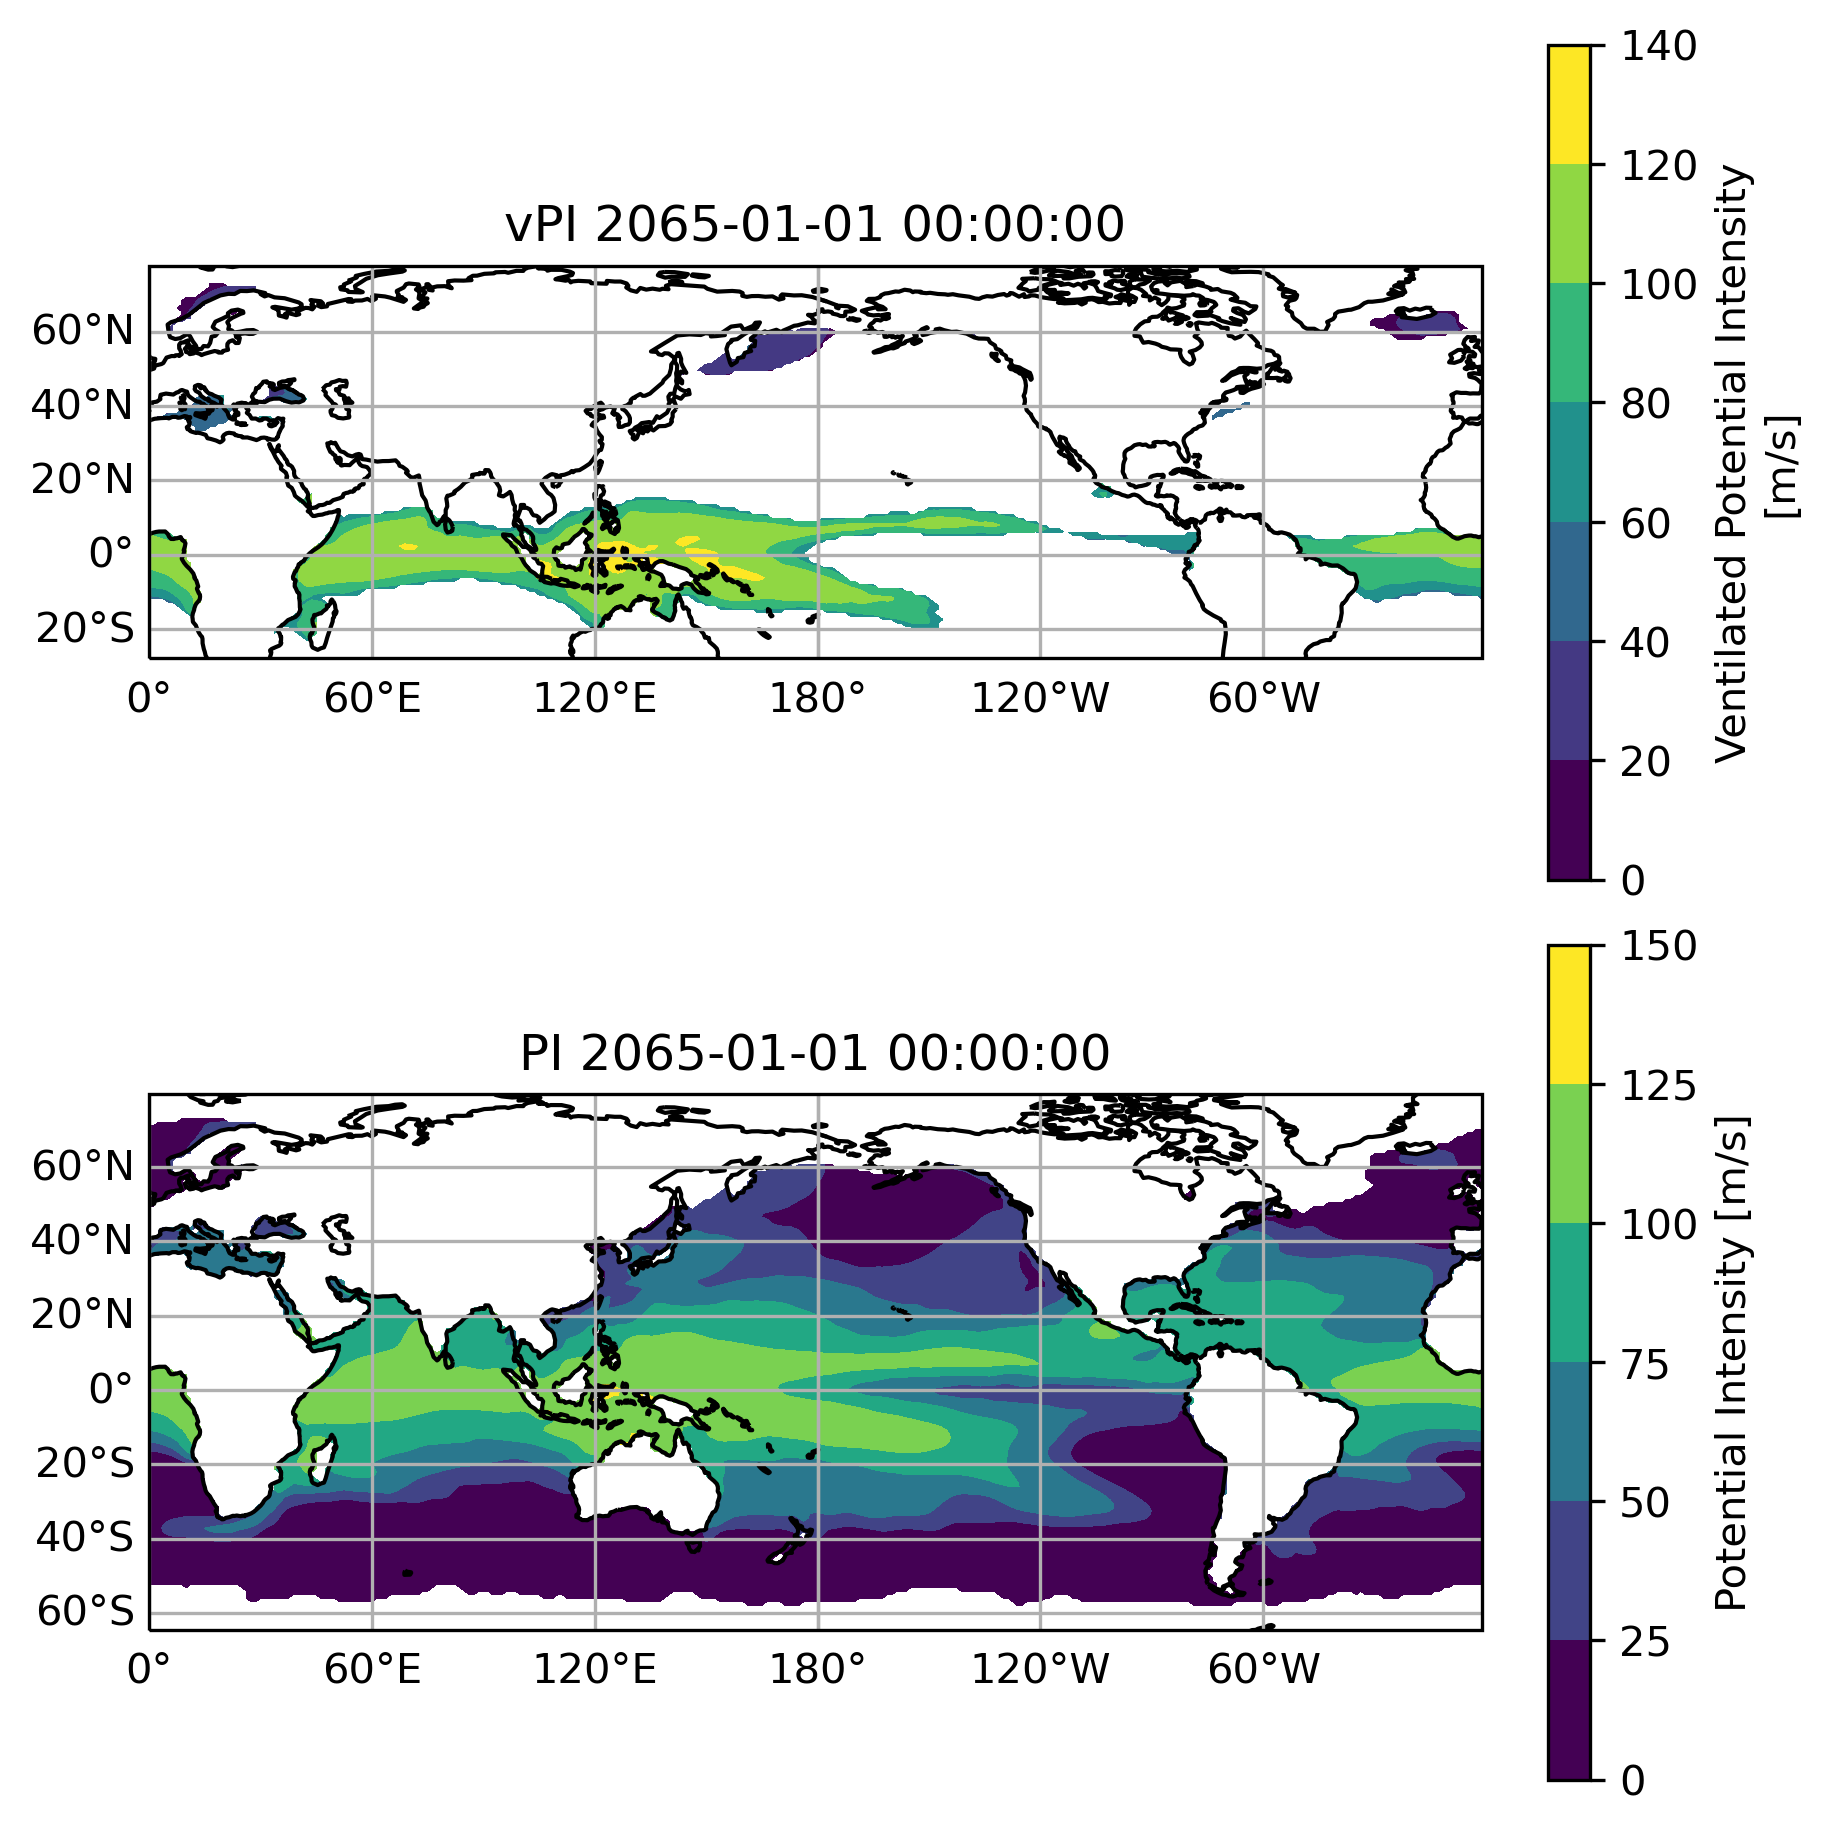

In [6]:
centlong=180
fig, ax = plt.subplots(2,figsize=(6, 6),constrained_layout=True,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=centlong)},dpi=300)

xr.plot.contourf(vPI,ax=ax[0],transform=ccrs.PlateCarree())
ax[0].set_title(f"vPI {ds.time.values}" )
ax[0].coastlines()
gl=ax[0].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

xr.plot.contourf(PI,ax=ax[1],transform=ccrs.PlateCarree())
ax[1].set_title(f"PI {ds.time.values}")
ax[1].coastlines()
gl=ax[1].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False